In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F 

# PSNR 계산 함수
def calculate_psnr(img1, img2, max_val=1.0):
    mse = torch.mean((img1 - img2) ** 2) 
    if mse == 0:
        return float('inf')  
    psnr = 10 * torch.log10(max_val**2 / mse)
    return psnr

# SSIM 계산 함수
def calculate_ssim(img1, img2, max_val=1.0):
    C1 = (0.01 * max_val) ** 2
    C2 = (0.03 * max_val) ** 2

    mu1 = F.avg_pool2d(img1, kernel_size=3, stride=1, padding=1)
    mu2 = F.avg_pool2d(img2, kernel_size=3, stride=1, padding=1)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 * img1, kernel_size=3, stride=1, padding=1) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 * img2, kernel_size=3, stride=1, padding=1) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=3, stride=1, padding=1) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

# 저해상도 이미지 생성 함수
def create_low_res_images(input_dir, output_dir, scale):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img = Image.open(os.path.join(input_dir, filename))
            lr_img = img.resize((img.width // scale, img.height // scale), Image.BICUBIC)
            lr_img.save(os.path.join(output_dir, filename))

# SRDataset 클래스 정의(학습 데이터DIV2K 사용)
class SRDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, transform=None, target_size=(256, 256)):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.hr_filenames = sorted(os.listdir(hr_dir))
        self.lr_filenames = sorted(os.listdir(lr_dir))
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.hr_filenames)

    def __getitem__(self, idx):
        hr_path = os.path.join(self.hr_dir, self.hr_filenames[idx])
        lr_path = os.path.join(self.lr_dir, self.lr_filenames[idx])

        hr_img = Image.open(hr_path).convert("RGB")
        lr_img = Image.open(lr_path).convert("RGB")
        hr_img = transforms.Resize(self.target_size)(hr_img)
        lr_img = transforms.Resize(self.target_size)(lr_img)

        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)

        return lr_img, hr_img

# SRCNN 모델 정의
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# 데이터 경로
train_hr_dir = r"C:\Users\kowm6\Desktop\SRdataset\DIV2K\DIV2K_train_HR"
train_lr_dir = r"C:\Users\kowm6\Desktop\SRdataset\DIV2K\DIV2K_train_LR"
valid_hr_dir = r"C:\Users\kowm6\Desktop\SRdataset\DIV2K\DIV2K_valid_HR"
valid_lr_dir = r"C:\Users\kowm6\Desktop\SRdataset\DIV2K\DIV2K_valid_LR"

# 데이터셋 및 DataLoader 설정
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = SRDataset(train_hr_dir, train_lr_dir, transform, target_size=(256, 256))
valid_dataset = SRDataset(valid_hr_dir, valid_lr_dir, transform, target_size=(256, 256))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 학습 및 검증 루프
num_epochs = 2
best_valid_loss = float('inf')
save_path = r"C:\Users\kowm6\Desktop\sr\best_model.pth"

for epoch in range(num_epochs):
    # 학습 루프
    model.train()
    train_loss = 0
    train_psnr = 0
    for lr_imgs, hr_imgs in train_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        preds = model(lr_imgs)
        loss = criterion(preds, hr_imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # PSNR 계산
        train_psnr += calculate_psnr(preds, hr_imgs)

    train_psnr /= len(train_loader)

    # 검증 루프
    model.eval()
    valid_loss = 0
    valid_psnr = 0
    valid_ssim = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in valid_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            preds = model(lr_imgs)
            valid_loss += criterion(preds, hr_imgs).item()

            # PSNR 및 SSIM 계산
            valid_psnr += calculate_psnr(preds, hr_imgs)
            valid_ssim += calculate_ssim(preds, hr_imgs)

    valid_psnr /= len(valid_loader)
    valid_ssim /= len(valid_loader)
    valid_loss /= len(valid_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Validation Loss: {valid_loss:.4f}, Train PSNR: {train_psnr:.4f}, "
          f"Validation PSNR: {valid_psnr:.4f}, Validation SSIM: {valid_ssim:.4f}")

    # 최적의 가중치 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
        print("Best model saved!")

# 테스트 데이터 평가
test_hr_dir = r"C:/Users/kowm6/Desktop/testlr"
test_lr_dir = r"C:/Users/kowm6/Desktop/testhr"
test_dataset = SRDataset(test_hr_dir, test_lr_dir, transform, target_size=(256, 256))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.load_state_dict(torch.load(save_path))
model.eval()

test_psnr = 0
test_ssim = 0
num_test_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        preds = model(lr_imgs)

        test_psnr += calculate_psnr(preds, hr_imgs)
        test_ssim += calculate_ssim(preds, hr_imgs)
        num_test_images += 1

test_psnr /= num_test_images
test_ssim /= num_test_images

print(f"Test PSNR: {test_psnr:.4f}, Test SSIM: {test_ssim:.4f}")


Epoch 1/2, Train Loss: 0.0574, Validation Loss: 0.0185, Train PSNR: 14.2296, Validation PSNR: 17.4362, Validation SSIM: 0.5050
Best model saved!
Epoch 2/2, Train Loss: 0.0113, Validation Loss: 0.0073, Train PSNR: 19.6674, Validation PSNR: 21.4736, Validation SSIM: 0.6553
Best model saved!
Test PSNR: 22.6087, Test SSIM: 0.7275


C:\Users\kowm6\AppData\Local\Temp\ipykernel_17876\2967394493.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


# TEST

C:\Users\kowm6\AppData\Local\Temp\ipykernel_2384\2496941367.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=

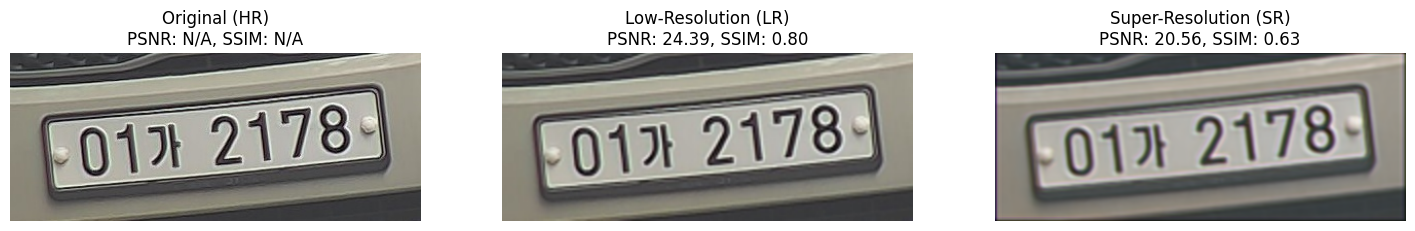

Enhanced image saved at: C:\Users\kowm6\Desktop\Plate\f_enhanced.jpg


In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torchvision.transforms.functional import resize


class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

def calculate_psnr(img1, img2, max_val=1.0):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(max_val**2 / mse)
    return psnr

def calculate_ssim(img1, img2, max_val=1.0):
    C1 = (0.01 * max_val) ** 2
    C2 = (0.03 * max_val) ** 2

    mu1 = F.avg_pool2d(img1, kernel_size=3, stride=1, padding=1)
    mu2 = F.avg_pool2d(img2, kernel_size=3, stride=1, padding=1)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 * img1, kernel_size=3, stride=1, padding=1) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 * img2, kernel_size=3, stride=1, padding=1) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=3, stride=1, padding=1) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SRCNN().to(device)
weights_path = r"C:\Users\kowm6\Desktop\sr\best_model.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

def visualize_and_compare(image_path, output_path, model, device, scale=2):
    """
    주어진 이미지를 SRCNN 모델로 화질 개선하고, 원본, 저해상도, 고해상도 이미지를 시각화.

    Args:
        image_path (str): 입력 원본 이미지 경로
        output_path (str): 결과 이미지 저장 경로
        model (torch.nn.Module): SRCNN 모델
        device (torch.device): GPU 또는 CPU
        scale (int): 저해상도 생성 시 축소 배율
    """

    hr_img = Image.open(image_path).convert("RGB")

    lr_img = hr_img.resize((hr_img.width // scale, hr_img.height // scale), Image.BICUBIC)
    lr_img_resized = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)  # 원본 크기로 확대

    
    transform = transforms.ToTensor()
    hr_tensor = transform(hr_img).unsqueeze(0).to(device)
    lr_tensor = transform(lr_img_resized).unsqueeze(0).to(device)

    
    with torch.no_grad():
        sr_tensor = model(lr_tensor).squeeze(0).cpu()

    
    to_pil = transforms.ToPILImage()
    sr_img = to_pil(sr_tensor)

    
    psnr_lr = calculate_psnr(lr_tensor, hr_tensor)
    psnr_sr = calculate_psnr(sr_tensor, hr_tensor.cpu())
    ssim_lr = calculate_ssim(lr_tensor, hr_tensor)
    ssim_sr = calculate_ssim(sr_tensor, hr_tensor.cpu())

    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"Original (HR)\nPSNR: N/A, SSIM: N/A")
    plt.imshow(hr_img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"Low-Resolution (LR)\nPSNR: {psnr_lr:.2f}, SSIM: {ssim_lr:.2f}")
    plt.imshow(lr_img_resized)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Super-Resolution (SR)\nPSNR: {psnr_sr:.2f}, SSIM: {ssim_sr:.2f}")
    plt.imshow(sr_img)
    plt.axis("off")

    plt.show()

    
    sr_img.save(output_path)
    print(f"Enhanced image saved at: {output_path}")


input_image_path = r"C:\Users\kowm6\Desktop\Plate\f.jpg"
output_image_path = r"C:\Users\kowm6\Desktop\Plate\f_enhanced.jpg"
visualize_and_compare(input_image_path, output_image_path, model, device, scale=2)
